In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble  import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import random

from sklearn import metrics
from collections import Counter
import argparse
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import ParameterGrid
import lightgbm as lgb
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

In [2]:
data = pd.read_csv("dapps_with_features_v4.csv")

In [3]:
RS = 42
SPLITS = 5

In [4]:
X = data.drop('category', axis=1)
y = data.category

In [5]:
X, X_test, y, y_test  = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RS)

In [6]:
print(f'X_train shape {X.shape}')
print(f'X_test shape {X_test.shape}')

X_train shape (1716, 17)
X_test shape (430, 17)


# Training on comments

## Check for possible meta-parameters

In [7]:
length_SC = X.SC_no_comments.apply(lambda x: len(x.split()))

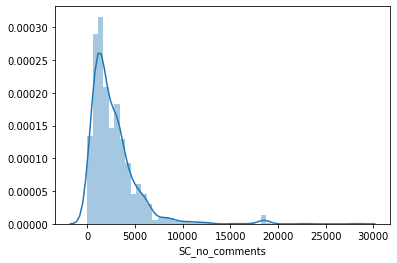

In [8]:
sns.distplot(length_SC)

In [9]:
length_SC.describe()

count     1716.000000
mean      2755.290210
std       2601.129827
min          5.000000
25%       1173.000000
50%       2068.000000
75%       3415.000000
max      28389.000000
Name: SC_no_comments, dtype: float64

In [10]:
X.SC_no_comments.str.split(expand=True).stack().value_counts()

newline                                                           2137095
}                                                                  125674
=                                                                  123833
{                                                                  120403
function                                                            92859
                                                                   ...   
channels[key].deposit                                                   1
require(IERC721(bountyNFTAddress).isApprovedForAll(msg.sender,          1
approvedTokenContracts                                                  1
if(compareStrings(termsKey,'dataCollection')){                          1
level3ActivationsFromLevel1CountSet                                     1
Length: 148175, dtype: int64

### Ridge

In [11]:
kf  = StratifiedKFold(n_splits=SPLITS, random_state=RS)

word_vectorizer   = TfidfVectorizer(
    sublinear_tf  = True,
    strip_accents = 'unicode',
    analyzer      = 'word',
    token_pattern = r'\w{1,}',
    #stop_words    = 'english',
    ngram_range   = (1, 1),
    max_features  = 40000) # max 144018

/home/RDC/zinovyee.hub/anaconda3/envs/dmc/lib/python3.8/site-packages/sklearn/model_selection/_split.py:292: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [12]:
c = 0
C_parameter = np.arange(0.1, 1.1, 0.1) 

# use best C

C_parameter = [1]

In [13]:
names = [f'aucroc_{i}' for i in ['development', 'exchanges', 'finance', 'gambling', 'games',
       'high-risk', 'marketplaces', 'media', 'other', 'social']]
names2 = [f'aucprc_{i}' for i in ['development', 'exchanges', 'finance', 'gambling', 'games',
       'high-risk', 'marketplaces', 'media', 'other', 'social']]
names.extend(names2)

In [14]:
for c_p in C_parameter:  
    metrics_cv = pd.DataFrame(np.zeros((SPLITS, len(names))), columns=names)
    for c, (train_index, val_index) in enumerate(kf.split(X, y)):

            X_train, X_val      = X.iloc[train_index]['comments'], X.iloc[val_index]['comments']
            y_train, y_val      = y.iloc[train_index], y.iloc[val_index] 
            word_vectorizer.fit(X_train)
            train_word_features = word_vectorizer.transform(X_train)
            val_word_features   = word_vectorizer.transform(X_val)
             
            le = LabelBinarizer()
            le.fit(y_train)
            
            y_train = le.transform(y_train)
            y_val = le.transform(y_val)
            
            for i, cl in enumerate(le.classes_):
                classifier = LogisticRegression(C=c_p, solver='sag', random_state=RS)
                classifier.fit(train_word_features, y_train[:,i])
                probs      = classifier.predict_proba(val_word_features)[:,1]
                auc_roc_class = roc_auc_score(y_val[:,i], probs)
                auc_pr_class = average_precision_score(y_val[:,i], probs)
                
                metrics_cv.loc[c, f'aucroc_{cl}'] = round(auc_roc_class, 3)
                metrics_cv.loc[c, f'aucprc_{cl}'] = round(auc_pr_class, 3)   
                
    print(f"C:{c_p} AUC ROC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0).mean(), 3)}")
    print(f"C:{c_p} AUC PRC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0).mean(), 3)}")

C:1 AUC ROC: 0.887
C:1 AUC PRC: 0.578


In [15]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0), 3)

aucroc_development     0.841
aucroc_exchanges       0.959
aucroc_finance         0.917
aucroc_gambling        0.909
aucroc_games           0.925
aucroc_high-risk       0.948
aucroc_marketplaces    0.874
aucroc_media           0.846
aucroc_other           0.851
aucroc_social          0.802
dtype: float64

In [16]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0), 3)

aucprc_development     0.420
aucprc_exchanges       0.937
aucprc_finance         0.802
aucprc_gambling        0.722
aucprc_games           0.827
aucprc_high-risk       0.679
aucprc_marketplaces    0.569
aucprc_media           0.221
aucprc_other           0.447
aucprc_social          0.156
dtype: float64

In [17]:
metrics_cv

,aucroc_development,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucroc_marketplaces,aucroc_media,aucroc_other,aucroc_social,aucprc_development,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk,aucprc_marketplaces,aucprc_media,aucprc_other,aucprc_social
0,0.815,0.959,0.885,0.901,0.926,0.939,0.889,0.850,0.831,0.798,0.288,0.936,0.733,0.785,0.855,0.580,0.555,0.210,0.416,0.134
1,0.839,0.971,0.924,0.899,0.908,0.951,0.839,0.844,0.806,0.730,0.478,0.950,0.833,0.628,0.772,0.664,0.616,0.319,0.371,0.089
2,0.916,0.965,0.925,0.901,0.928,0.930,0.832,0.843,0.859,0.846,0.453,0.943,0.809,0.716,0.841,0.743,0.450,0.206,0.512,0.216
3,0.894,0.977,0.961,0.904,0.944,0.966,0.922,0.875,0.873,0.797,0.525,0.964,0.883,0.722,0.852,0.645,0.662,0.193,0.480,0.163
4,0.742,0.923,0.891,0.940,0.920,0.952,0.887,0.816,0.884,0.841,0.358,0.893,0.754,0.761,0.813,0.761,0.564,0.178,0.455,0.180


In [18]:
# TRAIN ON WHOLE DATA AND PREDICT ON TEST
metrics = pd.DataFrame(np.zeros((1,len(names))), columns=names)
word_vectorizer.fit(X['comments'])
train_word_features  = word_vectorizer.transform(X['comments'])
test_word_features   = word_vectorizer.transform(X_test['comments'])

le = LabelBinarizer()
le.fit(y)

y_train = le.transform(y)
y_test_lb = le.transform(y_test)

for i, cl in enumerate(le.classes_):
    classifier = LogisticRegression(C=c_p, solver='sag', random_state=RS)
    classifier.fit(train_word_features, y_train[:,i])
    probs      = classifier.predict_proba(test_word_features)[:,1]
    auc_roc_class = roc_auc_score(y_test_lb[:,i], probs)
    auc_pr_class = average_precision_score(y_test_lb[:,i], probs)

    metrics.loc[0, f'aucroc_{cl}'] = round(auc_roc_class, 3)
    metrics.loc[0, f'aucprc_{cl}'] = round(auc_pr_class, 3)   

In [19]:
metrics

,aucroc_development,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucroc_marketplaces,aucroc_media,aucroc_other,aucroc_social,aucprc_development,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk,aucprc_marketplaces,aucprc_media,aucprc_other,aucprc_social
0,0.892,0.95,0.923,0.904,0.931,0.95,0.878,0.898,0.95,0.69,0.393,0.924,0.778,0.645,0.836,0.623,0.628,0.271,0.581,0.072


In [20]:
round(metrics.loc[:, metrics.columns.str.contains('aucroc')].mean(axis=1), 3)

0    0.897
dtype: float64

In [21]:
round(metrics.loc[:, metrics.columns.str.contains('aucprc')].mean(axis=1), 3)

0    0.575
dtype: float64

### Random Forest

In [22]:
kf  = StratifiedKFold(n_splits=SPLITS, random_state=RS)

word_vectorizer   = TfidfVectorizer(
    sublinear_tf  = True,
    strip_accents = 'unicode',
    analyzer      = 'word',
    token_pattern = r'\w{1,}',
    ngram_range   = (1, 1),
    max_features  = 40000) # max 144018

/home/RDC/zinovyee.hub/anaconda3/envs/dmc/lib/python3.8/site-packages/sklearn/model_selection/_split.py:292: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [23]:
metrics_cv = pd.DataFrame(np.zeros((SPLITS, len(names))), columns=names)
for c, (train_index, val_index) in enumerate(kf.split(X, y)):

        X_train, X_val      = X.iloc[train_index]['comments'], X.iloc[val_index]['comments']
        y_train, y_val      = y.iloc[train_index], y.iloc[val_index] 
        word_vectorizer.fit(X_train)
        train_word_features = word_vectorizer.transform(X_train)
        val_word_features   = word_vectorizer.transform(X_val)

        le = LabelBinarizer()
        le.fit(y_train)

        y_train = le.transform(y_train)
        y_val = le.transform(y_val)

        
        classifier          = RandomForestClassifier(n_estimators=600, max_depth=None, max_features='auto', 
                            min_samples_split=2, verbose = True, n_jobs=20, random_state=RS)
        classifier.fit(train_word_features, y_train)
        probs = classifier.predict_proba(val_word_features)
        
        for i, cl in enumerate(le.classes_):
            auc_roc_class = roc_auc_score(y_val[:,i], probs[i][:,1])
            auc_pr_class = average_precision_score(y_val[:,i], probs[i][:,1])

            metrics_cv.loc[c, f'aucroc_{cl}'] = round(auc_roc_class, 3)
            metrics_cv.loc[c, f'aucprc_{cl}'] = round(auc_pr_class, 3)   

print(f"C:{c_p} AUC ROC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0).mean(), 3)}")
print(f"C:{c_p} AUC PRC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0).mean(), 3)}")

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    1.2s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    2.8s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    4.0s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    0.9s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    1.1s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    2.8s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed: 

C:1 AUC ROC: 0.887
C:1 AUC PRC: 0.579


[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    0.8s finished


In [24]:
metrics_cv

,aucroc_development,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucroc_marketplaces,aucroc_media,aucroc_other,aucroc_social,aucprc_development,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk,aucprc_marketplaces,aucprc_media,aucprc_other,aucprc_social
0,0.835,0.960,0.900,0.913,0.913,0.954,0.892,0.827,0.835,0.808,0.304,0.936,0.755,0.807,0.840,0.606,0.560,0.197,0.418,0.286
1,0.823,0.979,0.935,0.891,0.891,0.924,0.838,0.826,0.793,0.751,0.299,0.954,0.831,0.569,0.785,0.605,0.590,0.293,0.357,0.073
2,0.904,0.972,0.948,0.907,0.930,0.946,0.911,0.848,0.860,0.891,0.478,0.941,0.863,0.674,0.856,0.699,0.525,0.263,0.508,0.279
3,0.897,0.980,0.951,0.912,0.947,0.957,0.959,0.756,0.878,0.820,0.499,0.959,0.876,0.719,0.885,0.615,0.628,0.128,0.473,0.214
4,0.695,0.939,0.881,0.954,0.924,0.934,0.815,0.829,0.885,0.810,0.388,0.897,0.736,0.757,0.828,0.648,0.560,0.364,0.506,0.136


In [25]:
# TRAIN ON WHOLE DATA AND PREDICT ON TEST
metrics = pd.DataFrame(np.zeros((1,len(names))), columns=names)
word_vectorizer.fit(X['comments'])
train_word_features  = word_vectorizer.transform(X['comments'])
test_word_features   = word_vectorizer.transform(X_test['comments'])

le = LabelBinarizer()
le.fit(y)

y_train = le.transform(y)
y_test_lb = le.transform(y_test)


classifier = RandomForestClassifier(n_estimators=600, max_depth=None, max_features='auto', 
                            min_samples_split=2, verbose = True, n_jobs=20, random_state=RS)
classifier.fit(train_word_features, y_train)
probs      = classifier.predict_proba(test_word_features)

for i, cl in enumerate(le.classes_):
    auc_roc_class = roc_auc_score(y_test_lb[:,i], probs[i][:,1])
    auc_pr_class = average_precision_score(y_test_lb[:,i], probs[i][:,1])

    metrics.loc[0, f'aucroc_{cl}'] = round(auc_roc_class, 3)
    metrics.loc[0, f'aucprc_{cl}'] = round(auc_pr_class, 3)   

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    1.2s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    3.0s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    4.4s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    0.9s finished


In [26]:
metrics

,aucroc_development,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucroc_marketplaces,aucroc_media,aucroc_other,aucroc_social,aucprc_development,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk,aucprc_marketplaces,aucprc_media,aucprc_other,aucprc_social
0,0.933,0.973,0.94,0.895,0.938,0.955,0.941,0.937,0.935,0.753,0.368,0.95,0.813,0.655,0.882,0.684,0.702,0.544,0.599,0.188


In [27]:
round(metrics.loc[:, metrics.columns.str.contains('aucroc')].mean(axis=1), 3)

0    0.92
dtype: float64

In [28]:
round(metrics.loc[:, metrics.columns.str.contains('aucprc')].mean(axis=1), 3)

0    0.639
dtype: float64

### SVM

In [29]:
penalty = ['l2', 'l1']
alpha = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
max_iter = [1000, 10000, 15000]

# best parameters
penalty = ['l1']
alpha = [0.00001]
max_iter = [1000] 

for p in penalty:
  for a in alpha:
    for it in max_iter:
      auc = []
      roc = []
      fscore_ = []
      c = 0
      # print performance
      print(f'-------------')
      print(f'penalty {p}')
      print(f'alpha {a}')
      print(f'max_iter {i}')
      print(f'-------------')
      
    
      metrics_cv = pd.DataFrame(np.zeros((SPLITS, len(names))), columns=names)
      for c, (train_index, val_index) in enumerate(kf.split(X, y)):

            X_train, X_val      = X.iloc[train_index]['comments'], X.iloc[val_index]['comments']
            y_train, y_val      = y.iloc[train_index], y.iloc[val_index] 
            word_vectorizer.fit(X_train)
            train_word_features = word_vectorizer.transform(X_train)
            val_word_features   = word_vectorizer.transform(X_val)
             
            le = LabelBinarizer()
            le.fit(y_train)
            
            y_train = le.transform(y_train)
            y_val = le.transform(y_val)
            
            for i, cl in enumerate(le.classes_):
                classifier = SGDClassifier(n_jobs=20, random_state=RS, loss='log', shuffle=False, 
                                    penalty=p, alpha=a, max_iter=it)
                classifier.fit(train_word_features, y_train[:,i])
                probs      = classifier.predict_proba(val_word_features)[:,1]
                auc_roc_class = roc_auc_score(y_val[:,i], probs)
                auc_pr_class = average_precision_score(y_val[:,i], probs)
                
                metrics_cv.loc[c, f'aucroc_{cl}'] = round(auc_roc_class, 3)
                metrics_cv.loc[c, f'aucprc_{cl}'] = round(auc_pr_class, 3)   
                
    print(f"C:{c_p} AUC ROC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0).mean(), 3)}")
    print(f"C:{c_p} AUC PRC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0).mean(), 3)}")

-------------
penalty l1
alpha 1e-05
max_iter 9
-------------
C:1 AUC ROC: 0.878
C:1 AUC PRC: 0.608


In [30]:
metrics_cv

,aucroc_development,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucroc_marketplaces,aucroc_media,aucroc_other,aucroc_social,aucprc_development,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk,aucprc_marketplaces,aucprc_media,aucprc_other,aucprc_social
0,0.852,0.953,0.876,0.894,0.939,0.913,0.824,0.871,0.885,0.826,0.312,0.931,0.751,0.754,0.848,0.547,0.606,0.435,0.561,0.201
1,0.691,0.962,0.920,0.888,0.898,0.935,0.897,0.906,0.802,0.660,0.398,0.947,0.821,0.590,0.767,0.682,0.681,0.382,0.383,0.112
2,0.720,0.956,0.919,0.905,0.917,0.933,0.830,0.800,0.836,0.861,0.360,0.932,0.811,0.717,0.834,0.694,0.459,0.303,0.549,0.333
3,0.929,0.970,0.960,0.943,0.956,0.956,0.939,0.805,0.831,0.856,0.617,0.966,0.875,0.782,0.887,0.698,0.763,0.177,0.478,0.235
4,0.712,0.933,0.898,0.941,0.933,0.918,0.849,0.790,0.860,0.847,0.436,0.913,0.773,0.799,0.856,0.679,0.627,0.446,0.497,0.191


In [31]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0), 3)

aucroc_development     0.781
aucroc_exchanges       0.955
aucroc_finance         0.915
aucroc_gambling        0.914
aucroc_games           0.929
aucroc_high-risk       0.931
aucroc_marketplaces    0.868
aucroc_media           0.834
aucroc_other           0.843
aucroc_social          0.810
dtype: float64

In [32]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0), 3)

aucprc_development     0.425
aucprc_exchanges       0.938
aucprc_finance         0.806
aucprc_gambling        0.728
aucprc_games           0.838
aucprc_high-risk       0.660
aucprc_marketplaces    0.627
aucprc_media           0.349
aucprc_other           0.494
aucprc_social          0.214
dtype: float64

In [33]:
# TRAIN ON WHOLE DATA AND PREDICT ON TEST
metrics = pd.DataFrame(np.zeros((1,len(names))), columns=names)
word_vectorizer.fit(X['comments'])
train_word_features  = word_vectorizer.transform(X['comments'])
test_word_features   = word_vectorizer.transform(X_test['comments'])

le = LabelBinarizer()
le.fit(y)

y_train = le.transform(y)
y_test_lb = le.transform(y_test)

for i, cl in enumerate(le.classes_):
    classifier = SGDClassifier(n_jobs=20, random_state=RS, loss='log', shuffle=False, 
                                    penalty=penalty[0], alpha=alpha[0], max_iter=max_iter[0])
    classifier.fit(train_word_features, y_train[:,i])
    probs      = classifier.predict_proba(test_word_features)[:,1]
    auc_roc_class = roc_auc_score(y_test_lb[:,i], probs)
    auc_pr_class = average_precision_score(y_test_lb[:,i], probs)

    metrics.loc[0, f'aucroc_{cl}'] = round(auc_roc_class, 3)
    metrics.loc[0, f'aucprc_{cl}'] = round(auc_pr_class, 3)   

In [34]:
metrics

,aucroc_development,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucroc_marketplaces,aucroc_media,aucroc_other,aucroc_social,aucprc_development,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk,aucprc_marketplaces,aucprc_media,aucprc_other,aucprc_social
0,0.859,0.984,0.922,0.881,0.945,0.965,0.927,0.872,0.92,0.681,0.305,0.959,0.806,0.689,0.905,0.706,0.741,0.497,0.673,0.204
